In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
# 因子3：趋势增强的上影线因子（KUP1_TREND）
def calculate_kup1_trend(df, trend_window=50):
    """
    结合趋势方向增强上影线因子
    公式：KUP1_TREND = (high - max(open, close)) / open * trend_strength
    原理：下跌趋势中的上影线更可靠
    """
    # 计算趋势强度（-1到1，负值为下跌趋势）
    df['ma'] = df['close'].rolling(trend_window).mean()
    df['trend_dir'] = np.where(df['close'] > df['ma'], 1, -1)
    df['trend_strength'] = (df['ma'] - df['close']) / df['ma'] * df['trend_dir']
    
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    base_kup1 = upper_shadow / df['open']
    
    # 趋势方向增强（下跌趋势中放大信号）
    return base_kup1 * df['trend_strength']

# 因子测试

In [6]:
evaluator.set_factor(
    factor_data_or_func=calculate_kup1_trend,
    factor_name='calculate_kup1_trend'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): -0.022911
   Rank_IC (Spearman): -0.013255
📊 信息比率:
   IR: -0.140633
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130696
   因子列: calculate_kup1_trend
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


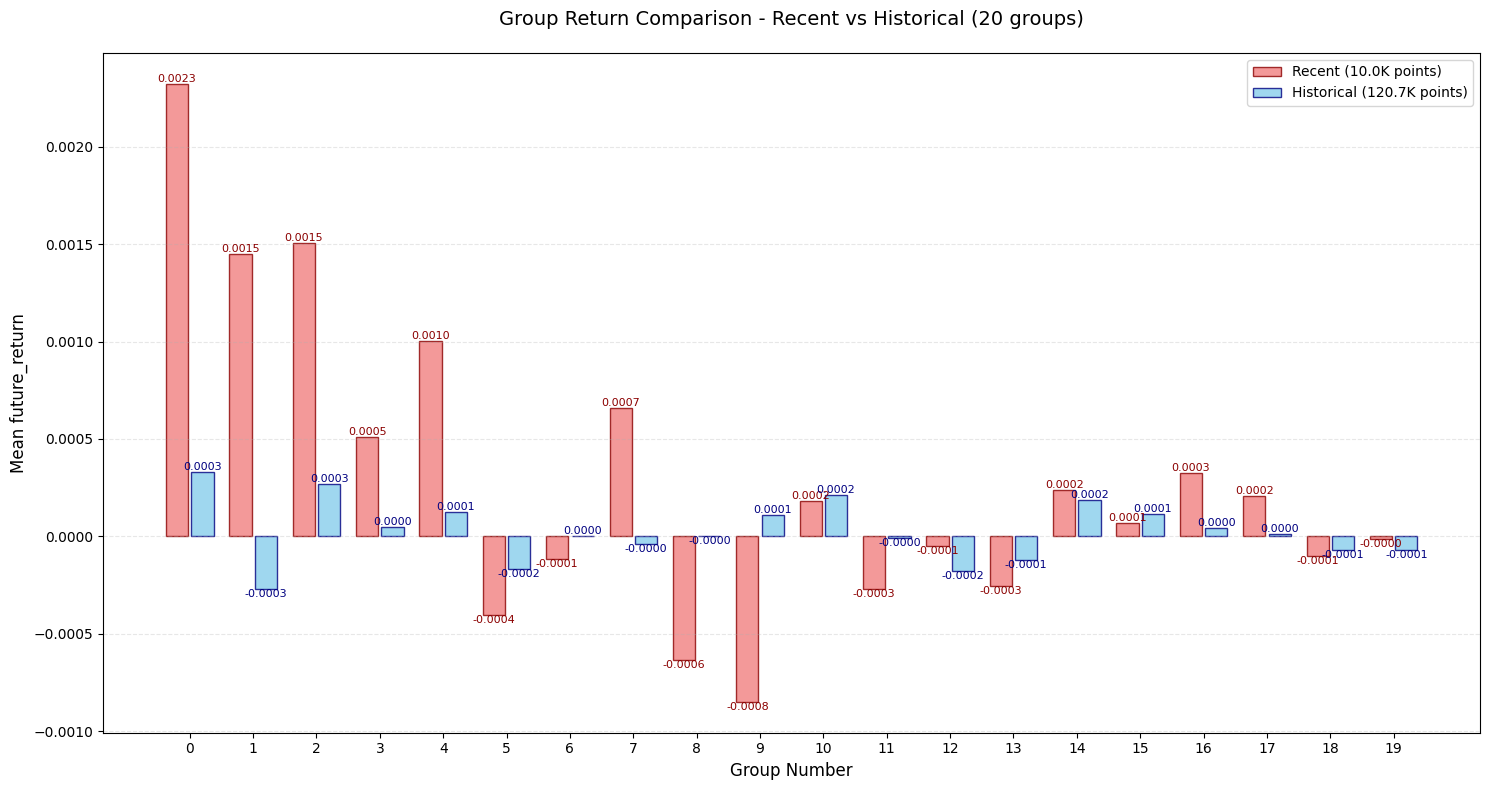

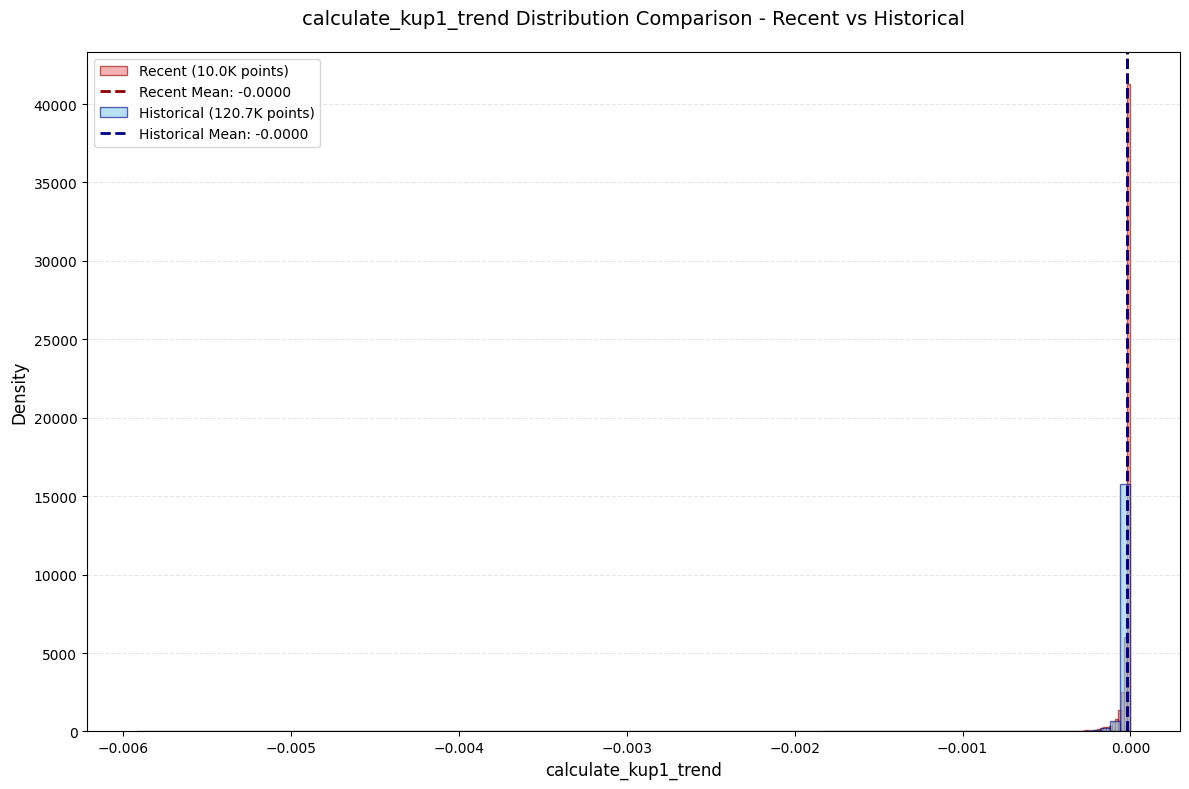

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [7]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)